<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python.ops.parallel_for.gradients import jacobian
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
np.indices((2,2))

array([[[0, 0],
        [1, 1]],

       [[0, 1],
        [0, 1]]])

In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [5]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [6]:
tf.reset_default_graph()

batch_size  = 256
hidden_size = 8

def inference(in_net):
    with tf.variable_scope('generator/inference', reuse=tf.AUTO_REUSE):
        net = tf.layers.dense(in_net, 512, name='dense_1', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 384, name='dense_2', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 256, name='dense_3', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 2*hidden_size, name='dense_5', activation=None)
    return net

def generator(in_net):
    with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
        net = tf.layers.dense(in_net, 256, name='dense_1', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 384, name='dense_2', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 512, name='dense_3', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 784, name='dense_5', activation=None)
    return net

lr    = tf.placeholder_with_default(0.001,shape=[])

x     = tf.placeholder(shape=[batch_size, 784], dtype=tf.float32)

prior = tfd.MultivariateNormalDiag(tf.zeros(hidden_size), scale_identity_multiplier=1.0)

mu, sigma        = tf.split(inference(x), 2, axis=-1)
sigma            = tf.nn.softplus(sigma) + 0.0001
approx_posterior = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

z = approx_posterior.sample()

sample_size = tf.placeholder_with_default(100,shape=[])

z_samples   = approx_posterior.sample(sample_size)

x_samples   = tfd.Independent(tfd.Bernoulli(logits=generator(z_samples))).sample(sample_size)

x_sims      = tfd.Independent(tfd.Bernoulli(logits=generator( prior.sample(batch_size)))).sample(sample_size)

data_likelihood = tfd.Independent(tfd.Bernoulli(logits=generator(z)))

kl_divergence   = tfd.kl_divergence(approx_posterior, prior)

shape1a         = tf.shape(data_likelihood.log_prob(x))

shape2a         = tf.shape(kl_divergence)

elbo            = - tf.reduce_mean(data_likelihood.log_prob(x) - kl_divergence,axis=0)

with tf.variable_scope("posterior2"):
    mu_t = tf.Variable(initial_value=np.zeros((batch_size,hidden_size)), dtype=tf.float32)
    sigma_t = tf.Variable(initial_value=np.ones((batch_size,hidden_size *(hidden_size +1) // 2)), dtype=tf.float32)
sigma_t2 = tfd.matrix_diag_transform(tfd.fill_triangular(sigma_t), transform=tf.nn.softplus)

approx_posterior2 = tfd.MultivariateNormalTriL(loc=mu_t,scale_tril=sigma_t2, name='posterior2')

z2                = approx_posterior2.sample()

zmean             = approx_posterior2.mean()

likeli_zmean      = tfd.Independent(tfd.Bernoulli(logits=generator(zmean)))

kl_divergence2    = tfd.kl_divergence(approx_posterior2, prior) 

shape1            = tf.shape(kl_divergence2)

mymask            = tf.placeholder_with_default(np.ones((784),dtype=int),shape=[784])

shape6            = tf.shape(generator(z2))

liklogits         = tf.boolean_mask(generator(z2), mymask, axis=1)

shape2            = tf.shape(liklogits)

data_likelihood2  = tfd.Independent(tfd.Bernoulli(logits=liklogits))

masked_x          = tf.boolean_mask(x, mymask, axis=1)

shape3            = tf.shape(masked_x)

shape4            = tf.shape(data_likelihood2.log_prob(masked_x))
    
elbo2             = -tf.reduce_mean(data_likelihood2.log_prob(masked_x)- kl_divergence2,axis=0)

shape5            = tf.shape(elbo2)

z2_samples        = approx_posterior2.sample(sample_size)

x2_samples        = tfd.Independent(tfd.Bernoulli(logits=generator(z2_samples))).sample(sample_size)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=5,zoom_range=0.1)
#datagen.fit(x_train.reshape((50000,28,28,1))) only needed if data trafos depend on the data itself

In [8]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
opt_op = optimizer.minimize(elbo)

opt_op2 = optimizer.minimize(elbo2,var_list=[mu_t,sigma_t])

Instructions for updating:
Use tf.cast instead.


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
losses_data = []

In [11]:
imgsv_full= x_valid.reshape((-1,28,28,1))
print(imgsv_full.shape)

(10000, 28, 28, 1)


In [14]:
nepochs     = 20
jj          = 0.
lrate_start = 1e-5
maxcount    = 10
ii          = 0

for ep in range(nepochs):
    gen  = datagen.flow(x_train.reshape((50000,28,28,1)), batch_size=batch_size)
    
    count = 0
    print('new epoch')
    lrate=lrate_start
    for i in range(50000 // batch_size):
        # Train the inference model
        imgs  = next(gen)

        imgsv = imgsv_full[ii*batch_size:(ii+1)*batch_size]

        if (len(imgsv) < batch_size) or ((ii+1)*batch_size==len(imgsv_full)):
          ii=0
          imgsv = imgsv_full[ii*batch_size:(ii+1)*batch_size]
        ii+=1
       
        
        if len(imgs) < batch_size:
            imgs = next(gen)

            
        imgs = imgs.reshape([-1,784])
        imgsv= imgsv.reshape([-1,784])

        # Train the generative model
        _, l  = sess.run([opt_op, elbo], feed_dict={x: imgs, lr:lrate})
        lv    = sess.run([elbo], feed_dict={x: imgsv})[0]
        
        if lv>l:
          jj+=1
        if l>lv:
          jj=0.
        
      
        losses_data.append(l)
        
        count += 1
        if count % 10 ==0:
            print(ep, l, lv, jj)
            
        if jj>maxcount:
            print('break criterion met')
            break
    if jj>(maxcount+5):
      break

new epoch
0 125.2274 114.75067 0.0
0 132.17957 119.002174 0.0
0 127.651474 120.029175 0.0
0 126.02329 113.576065 0.0
0 130.47668 112.24135 0.0
0 128.47455 112.58861 0.0
0 132.92596 116.020004 0.0
0 129.14676 120.29129 0.0
0 120.06804 122.44316 1.0
0 128.63057 116.36546 0.0
0 126.43914 114.574524 0.0
0 128.49663 119.09433 0.0
0 132.02061 115.28941 0.0
0 125.872116 116.518974 0.0
0 126.62253 119.89557 0.0
0 128.90944 109.93329 0.0
0 130.43567 114.3302 0.0
0 124.61559 113.74566 0.0
0 127.5791 109.95365 0.0
new epoch
1 128.06596 113.42733 0.0
1 129.87964 118.25706 0.0
1 125.61935 119.00362 0.0
1 129.41998 112.98408 0.0
1 127.884254 111.35948 0.0
1 126.63901 112.1265 0.0
1 125.96329 115.80922 0.0
1 132.98941 119.98685 0.0
1 127.60664 121.61107 0.0
1 128.84293 115.65514 0.0
1 127.73678 114.35084 0.0
1 126.132484 118.614365 0.0
1 125.86185 114.74246 0.0
1 126.660995 116.18189 0.0
1 126.628235 119.85603 0.0
1 131.50972 109.79407 0.0
1 125.47804 113.83405 0.0
1 126.91872 113.84265 0.0
1 130.698

KeyboardInterrupt: ignored

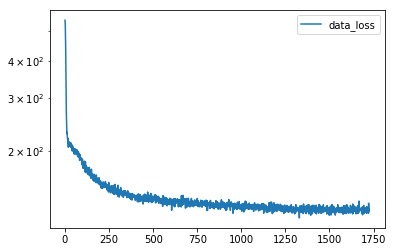

In [15]:
plot(losses_data,label='data_loss')
legend()
yscale('log')

In [0]:
res    = sess.run(z, feed_dict={x: x_test[0:batch_size]})
labels = targets_test[0:batch_size]

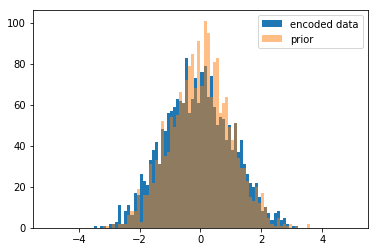

In [17]:
hist(res.flatten(),100,range=[-5,5],label='encoded data');
hist(randn(len(res.flatten())),100,range=[-5,5],alpha=0.5,label='prior');
legend()

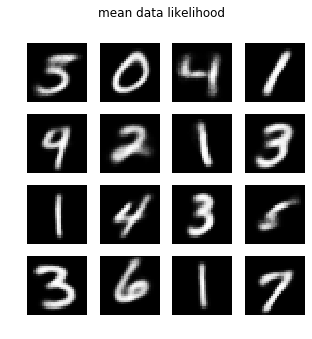

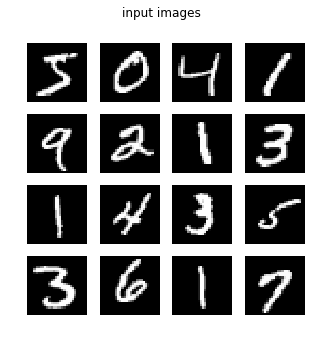

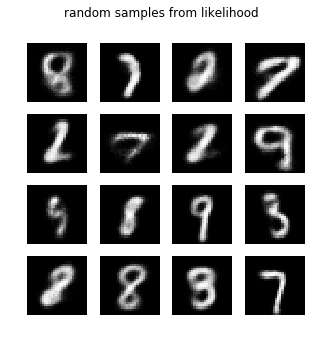

In [18]:
res, inim, s = sess.run([data_likelihood.mean(), x, x_sims], feed_dict={x: x_train[0:batch_size], sample_size: 400})
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(16):
    subplot(4,4,i+1)
    imshow((res )[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
figure(figsize=(5,5))
suptitle('input images')
for i in range(16):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('random samples from likelihood')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(s[:,i,:].reshape((-1,28,28)),axis=0),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:
mask = np.ones(IMAGE_SHAPE, dtype=int)
#mask[0:12,0:12]=0
mask = mask.reshape((28*28))

mask = np.asarray([mask]*batch_size)
#print(mask.shape)
masked_data = x_valid[0:batch_size]*mask

mask = np.ones(IMAGE_SHAPE, dtype=int)
#mask[0:12,0:12]=0
mask = mask.reshape((28*28))

In [20]:
#_, ll = sess.run([opt_op2, elbo2], feed_dict={x: masked_data, lr:lrate})
print(sess.run([shape1a,shape2a,shape6], feed_dict={x: masked_data, lr:lrate, mymask:mask}))
sess.run([shape1,shape2,shape3,shape4,shape5], feed_dict={x: masked_data, lr:lrate, mymask:mask})

[array([256], dtype=int32), array([256], dtype=int32), array([256, 784], dtype=int32)]


[array([256], dtype=int32),
 array([256, 784], dtype=int32),
 array([256, 784], dtype=int32),
 array([256], dtype=int32),
 array([], dtype=int32)]

In [0]:
posterior2_loss=[]

In [23]:
lrate=1e-4
for ii in range(1000):
  _, ll = sess.run([opt_op2, elbo2], feed_dict={x: masked_data, lr:lrate, mymask:mask})
  posterior2_loss.append(ll)
  if ii%100==0:
    mus, sigmas = sess.run([mu_t, sigma_t], feed_dict={x: masked_data})
    #print(mus[0:10])
  print(ll)

111.36456
110.76387
111.649185
110.82178
111.37315
111.61701
110.91594
111.1226
111.322075
111.28531
111.1444
111.42152
111.39673
111.298164
111.7106
111.16374
111.08432
110.930504
111.187325
111.45839
111.17449
111.06731
111.2996
111.17534
111.37005
111.24208
111.02915
111.24153
111.1236
111.44498
111.46999
111.237206
111.028244
111.35947
111.39375
111.382126
111.01829
111.55319
111.18244
111.241684
111.132355
111.13203
111.37805
111.21735
111.06639
111.31528
111.135605
111.20632
111.262184
111.146194
111.50955
111.25955
111.09361
110.98044
111.28949
111.19154
110.99627
111.04386
111.49485
111.07808
111.74568
111.0276
111.307434
111.382355
111.214035
111.31211
111.12117
111.25779
111.2249
111.013916
111.161255
111.11181
111.25122
111.36161
111.270035
111.2336
111.150116
111.581604
111.34971
111.05678
111.14928
111.058426
111.11522
110.92829
111.20834
111.27806
111.20113
111.10867
111.49231
111.26306
111.157005
110.95041
111.23128
111.36133
110.88305
111.39509
110.89497
111.37561
111.1

KeyboardInterrupt: ignored

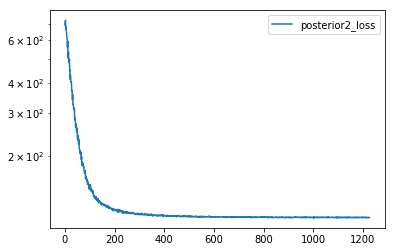

In [24]:
plot(posterior2_loss,label='posterior2_loss')
legend()
yscale('log')

In [0]:
res2 = sess.run(z2, feed_dict={x: masked_data[0:batch_size]})
res = sess.run(z, feed_dict={x: masked_data[0:batch_size]})

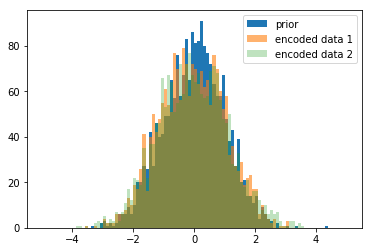

In [26]:
hist(randn(len(res.flatten())),100,range=[-5,5],label='prior');
hist(res.flatten(),100,range=[-5,5],alpha=0.6,label='encoded data 1');
hist(res2.flatten(),100,range=[-5,5],alpha=0.3,label='encoded data 2');
legend()

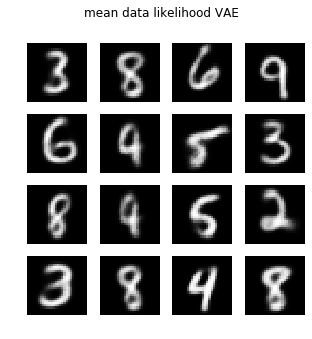

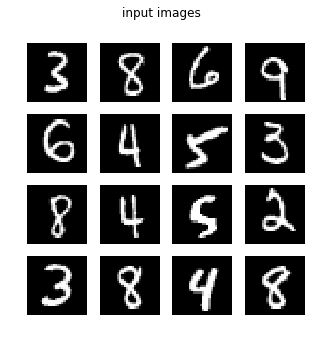

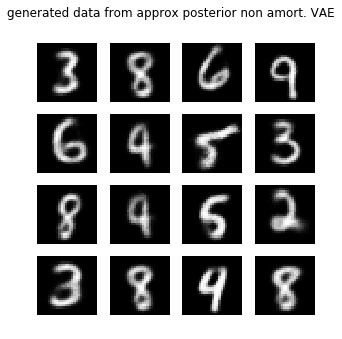

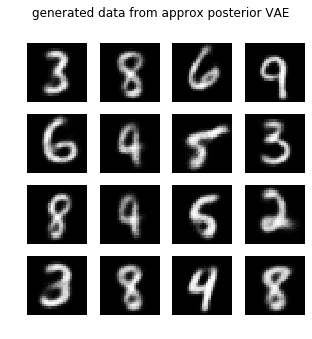

In [27]:
inim, xrecons2 = sess.run([x, x2_samples], feed_dict={x: masked_data[0:batch_size], sample_size: 20})
xmean, xrecon          = sess.run([data_likelihood.mean(),x_samples], feed_dict={x: masked_data[0:batch_size], sample_size: 20})


figure(figsize=(5,5))
suptitle('mean data likelihood VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow((xmean)[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')


# figure(figsize=(5,5))
# suptitle('mean data likelihood non amortized VAE')
# for i in range(16):
#     subplot(4,4,i+1)
#     imshow((res2)[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
#     axis('off')


figure(figsize=(5,5))
suptitle('input images')
for i in range(16):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

    
figure(figsize=(5,5))
suptitle('generated data from approx posterior non amort. VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(xrecons2[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
figure(figsize=(5,5))
suptitle('generated data from approx posterior VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(xrecon[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:
#has already been trained on one specific data set
data_from_mean_z = sess.run(likeli_zmean.mean(), feed_dict={x: masked_data[0:batch_size], mymask:mask, sample_size: 20})

(256, 784)


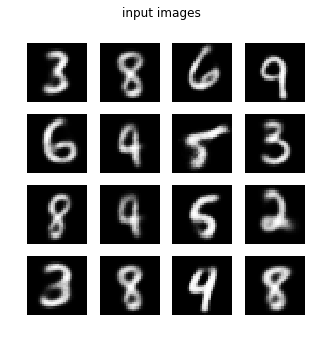

In [29]:
print(data_from_mean_z.shape)
figure(figsize=(5,5))
suptitle('input images')
for i in range(16):
    subplot(4,4,i+1)
    imshow(data_from_mean_z[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')


In [30]:
mask = np.ones(IMAGE_SHAPE, dtype=int)
mask[6:14,0:28]=0
mask = mask.reshape((28*28))

mask = np.asarray([mask]*batch_size)
print(mask.shape)
masked_data = x_valid[0:batch_size]*mask

mask = np.ones(IMAGE_SHAPE, dtype=int)
mask[6:14,0:28]=0
mask = mask.reshape((28*28))

(256, 784)


In [32]:
lrate=1e-4
for ii in range(1000):
  _, ll = sess.run([opt_op2, elbo2], feed_dict={x: masked_data, lr:lrate, mymask:mask})
  posterior2_loss.append(ll)
  if ii%100==0:
    mus, sigmas = sess.run([mu_t, sigma_t], feed_dict={x: masked_data, mymask:mask})
    print(mus[0:10])
  print(ll)

[[-9.68666375e-01  2.50261843e-01 -7.88609982e-02 -9.98772979e-01
   5.98259568e-01 -7.16044218e-04  8.18366468e-01 -2.03343558e+00]
 [ 8.01338017e-01  3.65319550e-01  5.15160859e-01 -1.73454583e+00
  -3.71628821e-01  4.92179334e-01 -1.59701139e-01 -1.06116915e+00]
 [-1.42087098e-02 -6.32915258e-01  3.49428236e-01  2.26409364e+00
  -5.14312387e-01  1.15005052e+00 -2.05753136e+00  4.22525615e-01]
 [-5.14110804e-01  8.58349442e-01  4.13691670e-01 -3.47582459e-01
  -2.62952375e+00  6.58221066e-01 -1.51004577e+00  1.08054101e+00]
 [ 1.10616124e+00 -1.13674831e+00  3.58958602e-01  5.03829658e-01
  -1.68765199e+00  1.75384593e+00  3.09807539e-01 -4.21865582e-01]
 [-1.62253439e-01  5.63766837e-01  1.16964865e+00  1.84630156e-01
  -1.35987091e+00  9.51673508e-01 -1.28632951e+00  5.24890304e-01]
 [ 1.80337596e+00  4.15548056e-01 -7.27400362e-01 -5.35138190e-01
   1.49749374e+00 -3.77550304e-01  2.14280677e+00  1.41175985e+00]
 [-6.66444182e-01 -5.84432185e-01 -8.69231403e-01 -2.97490329e-01
  -

KeyboardInterrupt: ignored

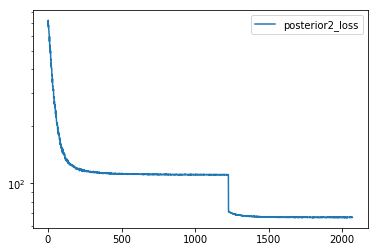

In [33]:
plot(posterior2_loss,label='posterior2_loss')
legend()
yscale('log')

In [0]:
res3 = sess.run(z2, feed_dict={x: masked_data[0:batch_size]})
#res = sess.run(z, feed_dict={x: masked_data[0:batch_size]})

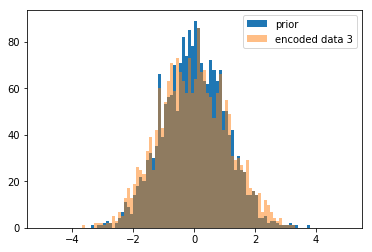

In [35]:
hist(randn(len(res3.flatten())),100,range=[-5,5],label='prior');
hist(res3.flatten(),100,range=[-5,5],alpha=0.5,label='encoded data 3');
legend()

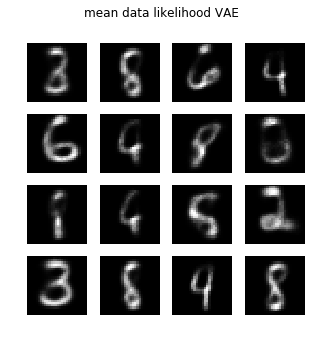

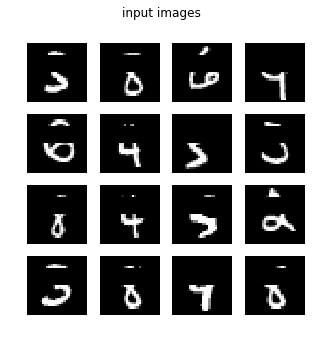

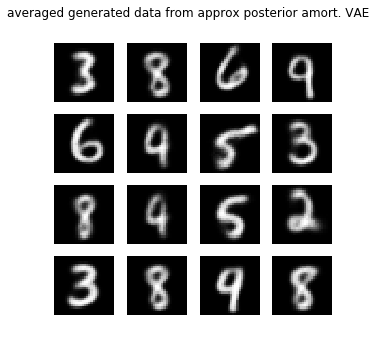

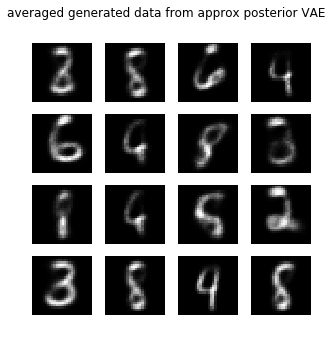

In [36]:
inim, xrecons2 = sess.run([x, x2_samples], feed_dict={x: masked_data[0:batch_size], sample_size: 40})
xmean, xrecon          = sess.run([data_likelihood.mean(),x_samples], feed_dict={x: masked_data[0:batch_size], sample_size: 40})

figure(figsize=(5,5))
suptitle('mean data likelihood VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow((xmean)[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')


# figure(figsize=(5,5))
# suptitle('mean data likelihood amortized VAE')
# for i in range(16):
#     subplot(4,4,i+1)
#     imshow((res2)[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
#     axis('off')


figure(figsize=(5,5))
suptitle('input images')
for i in range(16):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

    
figure(figsize=(5,5))
suptitle('averaged generated data from approx posterior amort. VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(xrecons2[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
figure(figsize=(5,5))
suptitle('averaged generated data from approx posterior VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(xrecon[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')